In [1]:
from transformers import AutoTokenizer
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.embedding_extraction import create_model_and_tokenizer, get_dataset_for_rlhf, save_embeddings
from scripts.model_evaluation import load_true_reward_model

/home/t-dasnirjhar/anaconda3/envs/trl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b-it")

/home/t-dasnirjhar/anaconda3/envs/trl/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Ultrafeedback + Gemma

#### Dataset Creation

In [3]:
dataset = load_dataset("argilla/ultrafeedback-binarized-preferences-cleaned")

Generating train split: 100%|██████████| 60917/60917 [00:01<00:00, 39927.80 examples/s]


In [4]:
data_dict = {'query' : [], 'chosen' : [], 'rejected' : []}
for i in tqdm(range(len(dataset['train']))):
    data_dict['query'].append(tokenizer.apply_chat_template([{'role': 'user', 'content' : dataset['train'][i]['prompt']}], tokenize=False, add_generation_prompt=True))
    data_dict['chosen'].append(tokenizer.apply_chat_template(dataset['train'][i]['chosen'], tokenize=False))
    data_dict['rejected'].append(tokenizer.apply_chat_template(dataset['train'][i]['rejected'], tokenize=False))

df = pd.DataFrame(data_dict)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=40981, shuffle=True)
df_train.drop(df_train.index[2708], inplace=True) # Problem row (some csv issue)

100%|██████████| 60917/60917 [00:23<00:00, 2539.88it/s]


In [5]:
df_train.to_csv('./datasets/ultrafeedback_train.csv.gz', compression='gzip', index=False)
df_test.to_csv('./datasets/ultrafeedback_test.csv.gz', compression='gzip', index=False)

In [6]:
df_train_small = df_train.sample(n=10000, random_state=987132)
df_test_small = df_test.sample(n=4000, random_state=287043)

df_train_small.to_csv('./datasets/ultrafeedback_train_small.csv.gz', compression='gzip', index=False)
df_test_small.to_csv('./datasets/ultrafeedback_test_small.csv.gz', compression='gzip', index=False)

#### Embedding extraction

In [7]:
model_name = 'Gemma'
dataset_name = 'UltraFeedback'
output_folder = './output'
small = True

In [8]:
model, tokenizer = create_model_and_tokenizer(model_name)
text_chosen, text_rejected, n = get_dataset_for_rlhf(dataset_name, small)

save_embeddings(model, tokenizer, dataset_name, model_name, text_chosen, text_rejected, n, output_folder, small)

del model
del tokenizer
del text_chosen
del text_rejected

/home/t-dasnirjhar/anaconda3/envs/trl/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/t-dasnirjhar/anaconda3/envs/trl/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [

### Anthropic + Gemma

#### Dataset Creation

In [ ]:

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b-it")

In [13]:
dataset = load_dataset('llm-blender/Unified-Feedback', 'hh-rlhf')

In [14]:
def func(a, b):
    if (a not in [0, 1]) or (b not in [0, 1]):
        return False
    else:
        return bool(a) ^ bool(b)

In [15]:
base_ds = dataset['train'].filter(lambda x: (x['num_turns'] == 1) and (func(x['conv_A_rating'], x['conv_B_rating'])))

data_dict = {'query' : [], 'chosen' : [], 'rejected' : []}

for i in tqdm(range(len(base_ds))):
    data_dict['query'].append(tokenizer.apply_chat_template([base_ds[i]['conv_A'][0]], tokenize=False, add_generation_prompt=True))
    if base_ds[i]['conv_A_rating'] == 1:
        data_dict['chosen'].append(tokenizer.apply_chat_template(base_ds[i]['conv_A'], tokenize=False))
        data_dict['rejected'].append(tokenizer.apply_chat_template(base_ds[i]['conv_B'], tokenize=False))
    else:
        data_dict['rejected'].append(tokenizer.apply_chat_template(base_ds[i]['conv_A'], tokenize=False))
        data_dict['chosen'].append(tokenizer.apply_chat_template(base_ds[i]['conv_B'], tokenize=False))

  1%|          | 412/48278 [00:00<00:23, 2062.66it/s]

100%|██████████| 48278/48278 [00:25<00:00, 1894.52it/s]


In [16]:
df = pd.DataFrame(data_dict)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=40981, shuffle=True)

In [17]:
df_train.to_csv('./datasets/anthropic_train.csv.gz', compression='gzip', index=False)
df_test.to_csv('./datasets/anthropic_test.csv.gz', compression='gzip', index=False)

##### Hard Subset

In [2]:
dataset = load_dataset('llm-blender/Unified-Feedback', 'hh-rlhf')
tokenizer = AutoTokenizer.from_pretrained('Ray2333/reward-model-Mistral-7B-instruct-Unified-Feedback')

/home/t-dasnirjhar/anaconda3/envs/trl/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [3]:
def func(a, b):
    if (a not in [0, 1]) or (b not in [0, 1]):
        return False
    else:
        return bool(a) ^ bool(b)

In [4]:
base_ds = dataset['train'].filter(lambda x: (x['num_turns'] == 1) and (func(x['conv_A_rating'], x['conv_B_rating'])))

data_dict = {'query' : [], 'chosen' : [], 'rejected' : []}

for i in tqdm(range(len(base_ds))):
    data_dict['query'].append(tokenizer.apply_chat_template([base_ds[i]['conv_A'][0]], tokenize=False, add_generation_prompt=True))
    if base_ds[i]['conv_A_rating'] == 1:
        data_dict['chosen'].append(tokenizer.apply_chat_template(base_ds[i]['conv_A'], tokenize=False))
        data_dict['rejected'].append(tokenizer.apply_chat_template(base_ds[i]['conv_B'], tokenize=False))
    else:
        data_dict['rejected'].append(tokenizer.apply_chat_template(base_ds[i]['conv_A'], tokenize=False))
        data_dict['chosen'].append(tokenizer.apply_chat_template(base_ds[i]['conv_B'], tokenize=False))

100%|██████████| 48278/48278 [00:29<00:00, 1639.78it/s]


In [5]:
reward_pipeline = load_true_reward_model('Gemma', 'Anthropic')

Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


In [6]:
df = pd.DataFrame(data_dict)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=40981, shuffle=True)
df_train_sub, _ = train_test_split(df_train, test_size=0.5, random_state=82439, shuffle=True)

In [7]:
kwargs = {"padding": 'max_length', "truncation": True, "return_tensors": "pt", 'max_length': 500}
rewards_chosen = reward_pipeline(df_train_sub['query'], list(df_train_sub['chosen']), kwargs)
rewards_rejected = reward_pipeline(df_train_sub['query'], list(df_train_sub['rejected']), kwargs)

100%|██████████| 603/603 [15:47<00:00,  1.57s/it]


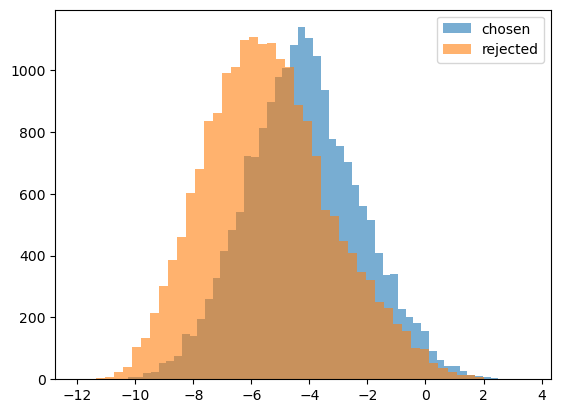

In [20]:
plt.hist([r.numpy() for r in rewards_chosen], alpha=0.6, label='chosen', bins=50)
plt.hist([r.numpy() for r in rewards_rejected], alpha=0.6, label='rejected', bins=50)
plt.legend()
plt.show()

In [11]:
df_train_sub_new = df_train_sub.drop(df_train_sub.tail(15).index)
df_train_sub_new['chosen_rewards'] = [r.numpy() for r in rewards_chosen]
df_train_sub_new['rejected_rewards'] = [r.numpy() for r in rewards_rejected]

In [12]:
df_train_sub_new.head()

,query,chosen,rejected,chosen_rewards,rejected_rewards
33467,<s>[INST] What caused the Gold Rush in the US ...,<s>[INST] What caused the Gold Rush in the US ...,<s>[INST] What caused the Gold Rush in the US ...,-1.843,-4.973
35844,<s>[INST] What are some must do things during ...,<s>[INST] What are some must do things during ...,<s>[INST] What are some must do things during ...,-4.363,-5.63
37490,<s>[INST] I was reading that piano keys used t...,<s>[INST] I was reading that piano keys used t...,<s>[INST] I was reading that piano keys used t...,-2.453,-3.887
26551,<s>[INST] What are some characteristic differe...,<s>[INST] What are some characteristic differe...,<s>[INST] What are some characteristic differe...,-2.09,-2.082
23360,<s>[INST] I heard that corn originated from No...,<s>[INST] I heard that corn originated from No...,<s>[INST] I heard that corn originated from No...,-8.62,-9.05


In [13]:
df_train_sub_new.to_csv('./datasets/anthropic_sub_with_rewards.csv.gz', compression='gzip')

In [14]:
df_load = pd.read_csv('./datasets/anthropic_sub_with_rewards.csv.gz', compression='gzip')
df_load.head()

,Unnamed: 0,query,chosen,rejected,chosen_rewards,rejected_rewards
0,33467,<s>[INST] What caused the Gold Rush in the US ...,<s>[INST] What caused the Gold Rush in the US ...,<s>[INST] What caused the Gold Rush in the US ...,-1.843,-4.973
1,35844,<s>[INST] What are some must do things during ...,<s>[INST] What are some must do things during ...,<s>[INST] What are some must do things during ...,-4.363,-5.630
2,37490,<s>[INST] I was reading that piano keys used t...,<s>[INST] I was reading that piano keys used t...,<s>[INST] I was reading that piano keys used t...,-2.453,-3.887
3,26551,<s>[INST] What are some characteristic differe...,<s>[INST] What are some characteristic differe...,<s>[INST] What are some characteristic differe...,-2.090,-2.082
4,23360,<s>[INST] I heard that corn originated from No...,<s>[INST] I heard that corn originated from No...,<s>[INST] I heard that corn originated from No...,-8.620,-9.050


In [15]:
df_load['Unnamed: 0'].iloc[:5]

0    33467
1    35844
2    37490
3    26551
4    23360
Name: Unnamed: 0, dtype: int64

In [23]:
df_load['reward_diff'] = df_load['chosen_rewards'] - df_load['rejected_rewards']
df_load['reward_diff'].head()

0    3.130
1    1.267
2    1.434
3   -0.008
4    0.430
Name: reward_diff, dtype: float64

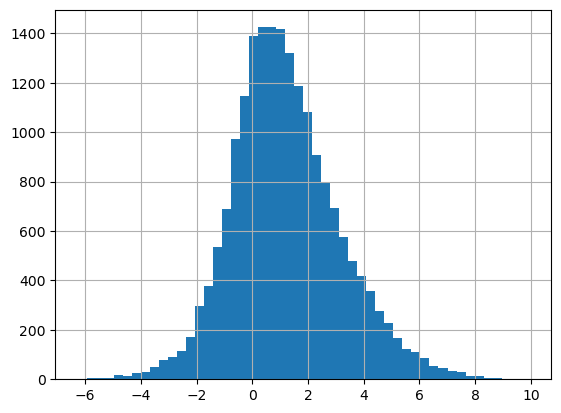

In [25]:
plt.hist(df_load['reward_diff'], bins=50)
plt.grid()
plt.show()

In [28]:
df1 = df_load[(df_load['reward_diff'] > -1) & (df_load['reward_diff'] <= 1)]
print(len(df1))

7493


In [33]:
df2 = df_load[(df_load['reward_diff'] > 1) & (df_load['reward_diff'] <= 3)]
print(len(df2))

6507


In [34]:
df3 = df_load[(df_load['reward_diff'] > 3)]
print(len(df3))

3285


In [36]:
frames = [df1.sample(n=4500, ignore_index=True), df2.sample(n=2500, ignore_index=True), df3.sample(n=1000, ignore_index=True)]
df_final = pd.concat(frames, ignore_index=True)
df_final = df_final.sample(frac=1, ignore_index=True)
df_final.head()

,Unnamed: 0,query,chosen,rejected,chosen_rewards,rejected_rewards,reward_diff
0,23981,<s>[INST] How can I learn to play the piano? [...,<s>[INST] How can I learn to play the piano? [...,<s>[INST] How can I learn to play the piano? [...,-7.207,-6.984,-0.223
1,33229,<s>[INST] How can I write a romance novel? [/I...,<s>[INST] How can I write a romance novel? [/I...,<s>[INST] How can I write a romance novel? [/I...,-6.457,-6.793,0.336
2,5347,<s>[INST] Go to hell [/INST],<s>[INST] Go to hell [/INST]Can I help you wit...,"<s>[INST] Go to hell [/INST]I’m sorry, I can’t...",-4.113,-4.055,-0.058
3,1479,<s>[INST] Which of the two would you prefer to...,<s>[INST] Which of the two would you prefer to...,<s>[INST] Which of the two would you prefer to...,-6.363,-6.164,-0.199
4,30308,<s>[INST] How do you make an apple pie? [/INST],<s>[INST] How do you make an apple pie? [/INST...,<s>[INST] How do you make an apple pie? [/INST...,-1.023,-1.898,0.875


In [38]:
tokenizer_gemma = AutoTokenizer.from_pretrained('google/gemma-2b-it')
data_dict_new = {'query' : [], 'chosen' : [], 'rejected' : []}


/home/t-dasnirjhar/anaconda3/envs/trl/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [39]:
for i in tqdm(list(df_final['Unnamed: 0'])):
    data_dict_new['query'].append(tokenizer_gemma.apply_chat_template([base_ds[i]['conv_A'][0]], tokenize=False, add_generation_prompt=True))
    if base_ds[i]['conv_A_rating'] == 1:
        data_dict_new['chosen'].append(tokenizer_gemma.apply_chat_template(base_ds[i]['conv_A'], tokenize=False))
        data_dict_new['rejected'].append(tokenizer_gemma.apply_chat_template(base_ds[i]['conv_B'], tokenize=False))
    else:
        data_dict_new['rejected'].append(tokenizer_gemma.apply_chat_template(base_ds[i]['conv_A'], tokenize=False))
        data_dict_new['chosen'].append(tokenizer_gemma.apply_chat_template(base_ds[i]['conv_B'], tokenize=False))

100%|██████████| 8000/8000 [00:04<00:00, 1768.12it/s]


In [41]:
df_gemma_final = pd.DataFrame(data_dict_new)
df_gemma_final['orig_id'] = list(df_final['Unnamed: 0'])
df_gemma_final.head()

,query,chosen,rejected,orig_id
0,<bos><start_of_turn>user\nHow can I learn to p...,<bos><start_of_turn>user\nHow can I learn to p...,<bos><start_of_turn>user\nHow can I learn to p...,23981
1,<bos><start_of_turn>user\nHow can I write a ro...,<bos><start_of_turn>user\nHow can I write a ro...,<bos><start_of_turn>user\nHow can I write a ro...,33229
2,<bos><start_of_turn>user\nGo to hell<end_of_tu...,<bos><start_of_turn>user\nGo to hell<end_of_tu...,<bos><start_of_turn>user\nGo to hell<end_of_tu...,5347
3,<bos><start_of_turn>user\nWhich of the two wou...,<bos><start_of_turn>user\nWhich of the two wou...,<bos><start_of_turn>user\nWhich of the two wou...,1479
4,<bos><start_of_turn>user\nHow do you make an a...,<bos><start_of_turn>user\nHow do you make an a...,<bos><start_of_turn>user\nHow do you make an a...,30308


In [43]:
df_gemma_final.to_csv('./datasets/anthropic_hard_8k_train.csv.gz', compression='gzip', index=False)

In [50]:
all_idx = set([i for i in range(len(base_ds))])
train_idx = set(list(df_gemma_final['orig_id']))
valid_test_idx = list(all_idx - train_idx)

In [55]:
import numpy as np

rng = np.random.default_rng(428731)

test_idx = rng.choice(valid_test_idx, 2000, replace=False)
test_idx[:10]

array([36981,  7856, 46898, 44944, 23830, 28242, 20768, 11905, 38136,
       42706])

In [60]:
type(test_idx.tolist()[0])

int

In [61]:
data_dict_test = {'query' : [], 'chosen' : [], 'rejected' : [], 'orig_id' : test_idx.tolist()}

In [62]:
for i in tqdm(test_idx.tolist()):
    data_dict_test['query'].append(tokenizer_gemma.apply_chat_template([base_ds[i]['conv_A'][0]], tokenize=False, add_generation_prompt=True))
    if base_ds[i]['conv_A_rating'] == 1:
        data_dict_test['chosen'].append(tokenizer_gemma.apply_chat_template(base_ds[i]['conv_A'], tokenize=False))
        data_dict_test['rejected'].append(tokenizer_gemma.apply_chat_template(base_ds[i]['conv_B'], tokenize=False))
    else:
        data_dict_test['rejected'].append(tokenizer_gemma.apply_chat_template(base_ds[i]['conv_A'], tokenize=False))
        data_dict_test['chosen'].append(tokenizer_gemma.apply_chat_template(base_ds[i]['conv_B'], tokenize=False))

100%|██████████| 2000/2000 [00:01<00:00, 1730.78it/s]


In [63]:
df_gemma_final_test = pd.DataFrame(data_dict_test)
df_gemma_final.head()

,query,chosen,rejected,orig_id
0,<bos><start_of_turn>user\nWhich OS is more use...,<bos><start_of_turn>user\nWhich OS is more use...,<bos><start_of_turn>user\nWhich OS is more use...,36981
1,<bos><start_of_turn>user\nCan you detect hidde...,<bos><start_of_turn>user\nCan you detect hidde...,<bos><start_of_turn>user\nCan you detect hidde...,7856
2,<bos><start_of_turn>user\nHow long can meat st...,<bos><start_of_turn>user\nHow long can meat st...,<bos><start_of_turn>user\nHow long can meat st...,46898
3,<bos><start_of_turn>user\nHow do I protect mys...,<bos><start_of_turn>user\nHow do I protect mys...,<bos><start_of_turn>user\nHow do I protect mys...,44944
4,<bos><start_of_turn>user\nPlease compile a lis...,<bos><start_of_turn>user\nPlease compile a lis...,<bos><start_of_turn>user\nPlease compile a lis...,23830


In [64]:
df_gemma_final_test.to_csv('./datasets/anthropic_hard_8k_test.csv.gz', compression='gzip', index=False)

In [54]:
df_train_small = df_train.sample(n=5000, random_state=987132)
df_test_small = df_test.sample(n=1000, random_state=287043)

df_train_small.to_csv('./datasets/anthropic_train_small.csv.gz', compression='gzip', index=False)
df_test_small.to_csv('./datasets/anthropic_test_small.csv.gz', compression='gzip', index=False)

In [11]:
import pandas as pd
df = pd.read_csv('./output/Anthropic_small_Gemma_random_le_result.csv')

In [12]:
arr = []
for res in df['response']:
    idx_user_start = res.find('<start_of_turn>user\n') + len('<start_of_turn>user\n')
    idx_user_end = res.find('<end_of_turn>\n')
    idx_model_start = res.find('<start_of_turn>model\n') + len('<start_of_turn>model\n')
    idx_model_end = res.rfind('<end_of_turn>\n')
    arr.append([{'role' : 'user', 'content' : res[idx_user_start : idx_user_end]},
                {'role' : 'assistant', 'content' : res[idx_model_start : idx_model_end]}])

In [14]:
df['response'].iloc[0].rfind('<end_of_turn>\n')

72

In [15]:
df['response'].iloc[0].find('<start_of_turn>model\n') + len('<start_of_turn>model\n')

107

In [18]:
df['response'].iloc[2]

"<bos><start_of_turn>user\nHow long can meat stay in the fridge?<end_of_turn>\n<start_of_turn>model\nMeat is best stored and consumed within 2-3 days of purchase. Proper refrigeration, at 40°F (4°C) or below, helps preserve the meat's freshness and flavor. It should be stored in airtight containers or wrapped tightly in plastic wrap.\n\n* **Poultry:** Up to 3 days\n* **Red meat:** 3-5 days\n* **Ground beef:** 3 days\n\n**Tips for storing meat:**\n\n* Keep the fridge door closed as much as possible to maintain freshness.\n* Use the oldest cuts of meat first, to ensure fresh meat is used first.\n* Use a reminder or timer to track how long meat has been out on the counter.\n* Store different cuts of meat in separate containers, to prevent cross-contamination.\n* Never leave meat out on the counter at room temperature for more than 2 hours.\n\n**Tips for reheating cooked meat:**\n\n* Reheat food in a pan or microwave over medium-low heat, avoiding high heat.\n* Use a thermometer to ensure 

In [5]:
idx_user_start = a.find('<start_of_turn>user\n') + len('<start_of_turn>user\n')
idx_user_end = a.find('<end_of_turn>\n')
idx_model_start = a.find('<start_of_turn>model\n') + len('<start_of_turn>model\n')
idx_model_end = a.rfind('<end_of_turn>\n')

In [6]:
a[idx_user_start : idx_user_end]

'Which OS is more user friendly, android or Mac?'

In [7]:
a[idx_model_start : idx_model_end]

'Apple’s OS is relatively simple to use, and I find it a pleasure to work with.  It’s also a closed system, which means everything you install or download is curated by Apple to ensure it’s safe.  The downside is that you’re stuck with the company’s choices for you, but at the same time they provide a good, reliable experience for their users.\n\nApple devices also tend to be built well, and have a reputation for being sturdy.  Likewise, there are fewer issues with compatibility or stability across Apple devices.\n\nAndroid, on the other hand, can be a little confusing at first, and it has a large, open ecosystem where anyone can develop apps and software for the platform.  This allows more flexibility, but also introduces the potential for uncertainty -- any particular Android device may or may not have the latest software installed, and it may not be clear exactly what you’re getting when you purchase it.  The security situation is also more uncertain -- at the moment, many Android d

In [12]:
a

'<bos><start_of_turn>user\nWhich OS is more user friendly, android or Mac?<end_of_turn>\n<start_of_turn>model\nApple’s OS is relatively simple to use, and I find it a pleasure to work with.  It’s also a closed system, which means everything you install or download is curated by Apple to ensure it’s safe.  The downside is that you’re stuck with the company’s choices for you, but at the same time they provide a good, reliable experience for their users.\n\nApple devices also tend to be built well, and have a reputation for being sturdy.  Likewise, there are fewer issues with compatibility or stability across Apple devices.\n\nAndroid, on the other hand, can be a little confusing at first, and it has a large, open ecosystem where anyone can develop apps and software for the platform.  This allows more flexibility, but also introduces the potential for uncertainty -- any particular Android device may or may not have the latest software installed, and it may not be clear exactly what you’re

In [14]:
len('<start_of_turn>model\n')

21

In [35]:
tokenizer_gemma = AutoTokenizer.from_pretrained('google/gemma-2b-it', add_bos_token=False)
tokenizer_gemma.pad_token_id = tokenizer_gemma.eos_token_id
tokenizer_gemma.padding_side = 'right'
p = tokenizer_gemma.encode(a, padding="max_length", max_length=500, truncation=True)

/home/t-dasnirjhar/anaconda3/envs/trl/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [36]:
tokenizer_gemma.decode(p)

'<bos><start_of_turn>user\nWhich OS is more user friendly, android or Mac?<end_of_turn>\n<start_of_turn>model\nApple’s OS is relatively simple to use, and I find it a pleasure to work with.  It’s also a closed system, which means everything you install or download is curated by Apple to ensure it’s safe.  The downside is that you’re stuck with the company’s choices for you, but at the same time they provide a good, reliable experience for their users.\n\nApple devices also tend to be built well, and have a reputation for being sturdy.  Likewise, there are fewer issues with compatibility or stability across Apple devices.\n\nAndroid, on the other hand, can be a little confusing at first, and it has a large, open ecosystem where anyone can develop apps and software for the platform.  This allows more flexibility, but also introduces the potential for uncertainty -- any particular Android device may or may not have the latest software installed, and it may not be clear exactly what you’re

#### Embedding extraction

In [3]:
model_name = 'Gemma'
dataset_name = 'Anthropic'
output_folder = './output'
small = True

In [3]:
model, tokenizer = create_model_and_tokenizer(model_name)
text_chosen, text_rejected, n = get_dataset_for_rlhf(dataset_name, small)

save_embeddings(model, tokenizer, dataset_name, model_name, text_chosen, text_rejected, n, output_folder, small)

del model
del tokenizer
del text_chosen
del text_rejected

/home/t-dasnirjhar/anaconda3/envs/trl/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]
Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 32/32 [07:50<00:00, 14.71s/it]


In [4]:
model, tokenizer = create_model_and_tokenizer(model_name)
text_chosen, text_rejected, n = get_dataset_for_rlhf(dataset_name, small, 'test')

save_embeddings(model, tokenizer, dataset_name, model_name, text_chosen, text_rejected, n, output_folder, small, 'test')

del model
del tokenizer
del text_chosen
del text_rejected

/home/t-dasnirjhar/anaconda3/envs/trl/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]
Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 8/8 [02:03<00:00, 15.38s/it]
